<a href="https://colab.research.google.com/github/aaaksenova/NN_methods/blob/change/NN_methods_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация твитов

I. CNN на уровне слов: модель берет слова, пропускает их через Embedding слой. По эмбеддингам проходит CNN c фильтрами с разным окном, полученные результаты конкатенируются друг с другом по глубине, по результату конкатенации еще один сверточный слой, далее max pooling over time, на выходе линейный слой + сигмоида, функция потерь BCELoss. (модель аналогична тому, что мы делали на паре по сверткам, но на уровне слов, а не символов)

II. комбинация эмбеддингов и символьных признаков: У этой модели два входа, один для эмбеддингов слов (предобученных или обучаемых), из них берем max или mean, делаем вектор для предложения, поверх линейный слой - получаем вектор X. Другой вход сети для символьного представления слов (это обучаемый Embedding слой, он будет брать на вход batch_size x symbols_len и сопоставлять каждому символу в каждом слове один эмбеддинг). Следующий слой сверточный, примените фильтры разных размеров. Результаты агрегируются с помощью max pooling over time и полученные векторы конкатенируются с вектором X.

Далее линейный слой + сигмоида, функция потерь BCELoss.

Баллы:

Embedding слой обучается внутри первой модели -- 1 балл

подгружаются обученные эмбеддинги для русского языка или fasttext эмбеддинги обучаются на всем корпусе с нуля и далее подгружаются в модель -- 1 балл

Первая модель правильно построена и обучается -- 1 балл

Правильно подготовленный класс Dataset для второй архитектуры (теперь вам нужно два словаря (word2id и symbol2id) и две матрицы для кодирования предложения: одна размера batch_size x seq_len, другая batch_size x sybmols_len ) -- 2 балла

Вторая модель правильно построена и обучается -- 2 балла

Для первой модели показано, что качество можно улучшить засчет работы с гиперпараметрами и/или доведения архитектуры (помогло изменение количества/размера фильтров, размера слоя/эмбеддингов, добавили Dropout и спаслись от переобучения, добавили слоев и т.д.) -- 1 балл

Для второй модели показано, что качество можно улучшить засчет работы с гиперпараметрами и/или доведения архитектуры (помогло изменение количества/размера фильтров, размера слоя/эмбеддингов, добавили Dropout и спаслись от переобучения, добавили слоев и т.д.) -- 1 балл

Сделана попытка анализа предсказаний, на примерах из тестовой выборки показано, какие случаи даются легко, а какие хуже - 1 балл

In [1]:
! wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
! wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv 

--2021-11-24 07:19:09--  https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r6u59ljhhjdg6j0/negative.csv [following]
--2021-11-24 07:19:09--  https://www.dropbox.com/s/raw/r6u59ljhhjdg6j0/negative.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc80e23936f94fe46f61b09d7331.dl.dropboxusercontent.com/cd/0/inline/BakklE8tNL4pzM36fAQk0w3BJOyk6VT604OWTFKhpD-Tk7DzhyJGTNQUf1SqVNAROmtvhRCwOt08uYxucQitPrCRZNWA1TK14Nj6DP_7i1Lglfd-iP0emP6v3Pc8sGjoqOT4RTvOePtVNXT2Gx30_xoQ/file# [following]
--2021-11-24 07:19:09--  https://uc80e23936f94fe46f61b09d7331.dl.dropboxusercontent.com/cd/0/inline/BakklE8tNL4pzM36fAQk0w3BJOyk6VT604OWTFKhpD-Tk7DzhyJGTNQUf1SqVNAROmtvhRCwOt08uYxucQitPrC

In [2]:
! pip install spacy --upgrade
! python -m spacy download ru_core_news_md

     |████████████████████████████████| 6.0 MB 1.5 MB/s 
     |████████████████████████████████| 181 kB 49.9 MB/s 
     |████████████████████████████████| 10.1 MB 28.1 MB/s 
     |████████████████████████████████| 451 kB 37.8 MB/s 
     |████████████████████████████████| 628 kB 45.2 MB/s 
     |████████████████████████████████| 42 kB 1.5 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 43.0 M

In [3]:
! pip install torchmetrics
! pip install ipdb

     |████████████████████████████████| 329 kB 3.9 MB/s 
     |████████████████████████████████| 790 kB 3.9 MB/s 
     |████████████████████████████████| 374 kB 31.5 MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=0e052bed55ff6d946b206fcf232289cd61e36ef43729517a8892ec693fad00c7
  Stored in directory: /root/.cache/pip/wheels/65/cd/cc/aaf92acae337a28fdd2aa4d632196a59745c8c39f76eaeed01
Successfully built ipdb
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires p

In [5]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from sklearn.metrics import f1_score
import ipdb
from tqdm.auto import tqdm
import random
import spacy

In [6]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
all_tweets_data = pos_tweets.append(neg_tweets)

In [7]:
all_tweets_data = pos_tweets.append(neg_tweets)
all_tweets_data.tone.replace({-1: 0}, inplace=True)
all_tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

In [ ]:
nlp = spacy.load('ru_core_news_md') # Вообще в спэйси есть пайплайн для смайликов классный но мы живем в россии и для нас он не доступен

In [8]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

In [9]:
def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
import re
tqdm_notebook.pandas()

all_tweets_data['clean'] = all_tweets_data.text.progress_apply(lambda x: preprocess_text(x))
all_tweets_data.to_csv('cleaned_data.csv')

  0%|          | 0/100000 [00:00<?, ?it/s]

In [13]:
all_tweets_data = pd.read_csv('cleaned_data.csv')

In [14]:
all_tweets_data['clean'] = all_tweets_data['clean'].astype(str)

In [15]:
train_sentences, val_sentences = train_test_split(all_tweets_data, test_size=0.2)

In [16]:
train_sentences[:10]

,Unnamed: 0,text,tone,clean
82887,24198,неисправность локализована. поставлена временн...,0,неисправность локализована поставлена временна...
48328,17513,"Хочу сделать прогноз. Так сложилось, что к кон...",0,хочу сделать прогноз так сложилось что к концу...
59205,61199,RT @KorablevaSonya: я очень буду скучать по ва...,0,rt USER я очень буду скучать по вам URL
24419,11459,@alina_delicious олег так изчез когда выпал сн...,0,USER олег так изчез когда выпал снег и он поех...
99720,88402,@JMozyrets о госпоодиии...что со мной таке.Юляя(,0,USER о госпоодиии что со мной таке юляя
6212,34845,"@chemikadze ничего, нам же за это не платят ((...",0,USER ничего нам же за это не платят только есл...
95212,71893,RT @Pasha_SHM: @taniushka_tanya @alenaforever1...,1,rt USER USER USER USER USER я тоже
776,76875,Разбила сироп( Потому что я молодец! а вообще ...,0,разбила сироп потому что я молодец а вообще об...
62381,14751,И такая скорость уже 2 ой час-((..снег и дождь...,0,и такая скорость уже 2 ой час снег и дождь что...
47674,73175,Офигенно 1-го числа аллергия и отравление!но б...,0,офигенно 1 го числа аллергия и отравление но б...


In [128]:
vocab = Counter()
for line in tqdm(all_tweets_data.clean):
    vocab.update(line.split())

  0%|          | 0/100000 [00:00<?, ?it/s]

In [129]:
vocab.most_common(10)

[('USER', 65822),
 ('не', 32945),
 ('я', 29269),
 ('и', 27058),
 ('в', 25202),
 ('на', 16870),
 ('rt', 16671),
 ('а', 15991),
 ('что', 15860),
 ('URL', 14600)]

In [130]:
word2id = {'PAD':0}

for word in vocab.keys():
    word2id[word] = len(word2id)

In [131]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

## Датасет и даталоадер

In [132]:
class MyDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['clean'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y



    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [220]:
train_dataset = MyDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

## Модель

Делаем предобученные эмбеддинги (семинар mlp)


In [23]:
from gensim.models import FastText

In [24]:
ft = FastText(all_tweets_data['clean'].tolist(), size=100, window=5, min_count=1)

In [25]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = ft.wv[word]    
    except KeyError:
      count += 1
      # oov словам сопоставляем случайный вектор
      weights[i] = np.random.normal(0,0.1,100)

In [158]:
class CNN(nn.Module):
    # В дз требуется модель с эмбеддинг слоем, свертками и пулингом
    # Делаем только биграммы и триграммы потому что тексты короткие, а данных не очень много, свертки очень сильно переобучаются
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_cat = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.relu(self.trigrams(embedded))
        #batch_size x filter_count3 x seq_len*


        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.pooling(self.relu(self.bigrams_over_cat(concat)))
        pooling = bigrams.max(2)[0] 

        # batch _size x (filter_count2 + filter_count3)
        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [135]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    set_random_seed(142)

    losses = []
    val_losses = []
    val_losses_epoch = []
    val_f1 = []
    val_f1_epoch = []

    print('Training ... ')
    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='green')
            model.train()
            for x, y in train_loader:

                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()  # считаем градиенты  
                optimizer.step()
                losses.append(loss.item())
                
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            progress_bar.close()


            if (n_epoch + 1) % 5 == 0:
                print('Validating ... ')
                progress_bar = tqdm(total=len(val_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='blue')
                val_loss = 0
                epoch_metric = 0
                model.eval() 
                with torch.no_grad():
                    for i, (texts, ys) in enumerate(val_loader):   
                        preds = model(texts)  # делаем предсказания на тесте
                        count_loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
                        val_f1.append(f1_score(preds.round().cpu().detach().numpy(), ys.cpu().detach().numpy()))
                        epoch_metric += f1_score(preds.round().cpu().detach().numpy(), ys.cpu().detach().numpy())
                        val_losses.append(count_loss.item())
                        val_loss += count_loss.item()
                        progress_bar.set_postfix(f1_score=np.mean(val_f1[-10:]), loss=np.mean(val_losses[-10:]))
                        progress_bar.update(texts.shape[0])
                val_f1_epoch.append(epoch_metric / len(val_loader))
                val_losses_epoch.append(val_loss / len(val_loader)) 
                progress_bar.close()
                if n_epoch + 1 < epochs:
                    print('Training ... ')
        except KeyboardInterrupt:

            progress_bar.close()
            break
    return losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch

In [159]:
model = CNN(len(word2id), 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [38]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [221]:
set_random_seed(100)
val_dataset = MyDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [161]:
set_random_seed(100)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, 10)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

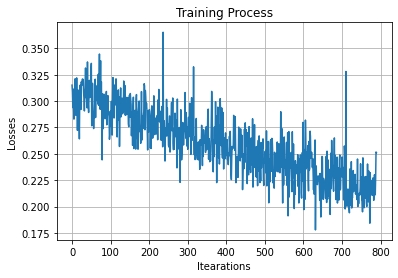

In [162]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

Итоговые метрики по последней эпохе

In [163]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.7806100875139237
0.7123539275189337


## Другой оптимизатор

In [164]:
model = CNN(len(word2id), 2)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [165]:
set_random_seed(100)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, 10)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

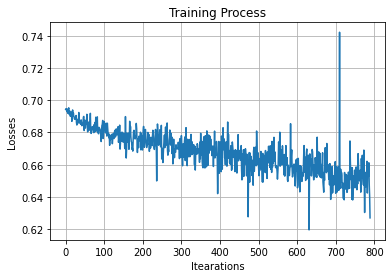

In [166]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

Итоговые метрики

In [167]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.647819060087204
0.5793062481716387


## Улучшенная модель

In [168]:
class CNN_upd(nn.Module):
    # Добавили DropOut
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_cat = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        #batch_size x seq_len
        embedded = self.embedding(word)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))
        #batch_size x filter_count3 x seq_len*


        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.dropout(self.pooling(self.relu(self.bigrams_over_cat(concat))))
        pooling = bigrams.max(2)[0] 

        # batch _size x (filter_count2 + filter_count3)
        logits = self.dropout(self.hidden(pooling))
        logits = self.out(logits)      
        return logits

In [234]:
set_random_seed(100)
model = CNN_upd(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [170]:
set_random_seed(100)
val_dataset = MyDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [235]:
set_random_seed(100)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, 50)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 11:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 15:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 16:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 20:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 21:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 25:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 26:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 30:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 31:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 35:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 36:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 40:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 41:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 45:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 46:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 50:   0%|          | 0/20000 [00:00<?, ?it/s]

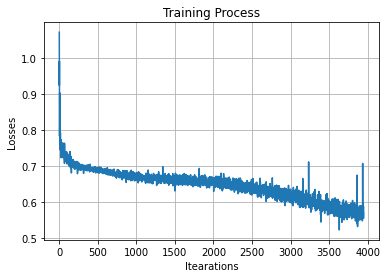

In [236]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

In [237]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.5945082604885101
0.7556649249029168


Ура, дропаут и weight decay спасли от переобучения

In [238]:
preds = []
sentences = []
trues = []
for i, (words, ys) in enumerate(val_iterator):   
    preds.extend(model(words).cpu().detach().numpy().round())
    sentences.extend(words)
val_sentences['pred'] = preds

In [239]:
# False positives
print('False positives', len(val_sentences[(val_sentences['pred'] == 1) & (val_sentences['tone'] == 0)]['text'].tolist()) / val_sentences.shape[0])
val_sentences[(val_sentences['pred'] == 1) & (val_sentences['tone'] == 0)]['text'].tolist()[:10]

False positives 0.21805


['@MrPushisty да не особо сложная, но она для os x, а зомби - наше все (((',
 '@Lightana_ не заметила, что тебя упомянула ((',
 '@potiekhina1923 @Potekhina1997 как горько видеть когда,браки рушаться(',
 '@volshebnicaa У меня тоже несколько дней уже :( А последние несколько дней вообще, ощущение, что мой мозг сжимают.',
 'Всем нравятся мои перчатки, кроме меня :(',
 'RT @CIO_Optimal: @latnick65 Молодцы пенсионерки!!! Очень плохо, что мало таких...',
 '@luda_1D это можно просто писать?\nограничения есть?\nахах\nрасскажи, пожалуйста, а то я не знаю:(',
 'Ася, ты меня проклинешь за наушники:(( @asya_milka777',
 '@OneFuckingDay на дополнительных был,а потом сочинение на конкурс писал(',
 'качество супер конечно :(\nтолько достал фотик и тут батарея разряжена ! http://t.co/tfNee94kkr']

In [240]:
# False negatives
print('False negatives', len(val_sentences[(val_sentences['pred'] == 0) & (val_sentences['tone'] == 1)]['text'].tolist()) / val_sentences.shape[0])
val_sentences[(val_sentences['pred'] == 0) & (val_sentences['tone'] == 1)]['text'].tolist()[:10]

False negatives 0.0655


['2) Пунктуальность 4ever. Охрененно же, когда девушка опаздывает, а он угрюмо смотрит на её попытки перед ним извиниться.',
 '"Моются те,кому лень чесаться" А.Фоменко Выходит , я -ленивая)))))',
 '@maskuznetsova ааа! я чет сначала подумала что у Леши на три года) А Илари и Стива да, надо) А то мы не переживем)',
 'RT @AndreyShmidt98: Теперь блин жду не дождусь 21!)',
 'RT @cyluxiryfeku: у кого бы Nokia E90 потыркать? Охота попробовать, а на новую бабла жалко :)',
 'Дома так темно:)\nСтрашно мне одной летать в темноте ',
 'как попрет на умные мысли,высказывания ,фразы ,что аж блин не по себе становится :) http://t.co/sOUlNWedF2',
 '@kaaareva а вот мне никто не попадается с моим именем)',
 '@adomogarov Александр Юрьевич, как встретила Казань?!) Им посчастливилось услышать "Лирическую"?! Поделитесь впечатлениями, пожалуйста!)',
 '@yulchik1997 моим посрать когда,у них бы вечно были открыты окна если бы не было орущего ребенка в доме))']

Итак, лучшая модель склонна предсказывать положительный класс. Кажется, четкую закономерность на ошибочно классифицированных примерах выделить не получается, но, например, видно, что модель не раличает сарказм и реплики со словами "супер", "отлично", "молодец" скорее относит к положительному классу


При этом очень часто в примерах с частицей "не" модель выставляет отрицальельную тональность (см примеры выше, дальше закономерность сохраняется)

Все еще плохо, давайте поработаем с данными. Сейчас у нас убираются смайлики и знаки препинания, посмотрим что будет, если мы это не сделаем

## Модель без предобработки текста

In [90]:
vocab = Counter()
for line in tqdm(all_tweets_data.text):
    vocab.update(tt.tokenize(line))

word2id = {'PAD':0}

for word in vocab.keys():
    word2id[word] = len(word2id)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [91]:
class RawDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = tt.tokenize(self.dataset[index])
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y



    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [92]:
model = CNN(len(word2id), 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [93]:
set_random_seed(100)
train_dataset = RawDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [94]:
set_random_seed(100)
val_dataset = RawDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [96]:
set_random_seed(100)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = train(model, train_iterator, val_iterator, optimizer, criterion, 50)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 11:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 15:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 16:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 20:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 21:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 25:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 26:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 30:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 31:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 35:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 36:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 40:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 41:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 45:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 46:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 50:   0%|          | 0/20000 [00:00<?, ?it/s]

In [97]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.05814386270940304
0.9795989886925556


Кажется, вывод отсюда один: не всегда нужно предобрабатывать данные, потому что для сеток нужно много признаков и большой словарь, а когда у нас словарь маленький, все очень быстро переобучается

# Модель с двумя входами

## Датасет и даталоадер

https://github.com/joaomvg/ConvNN_Text_classifier/blob/master/CNN_hybrid_word_character.ipynb 

In [98]:
vocab = Counter()
for line in tqdm(all_tweets_data.clean):
    vocab.update(line.split())
    
word2id = {'PAD':0}

for word in vocab.keys():
    word2id[word] = len(word2id)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [99]:
char_vocab = Counter()
for line in tqdm(all_tweets_data.clean):
    char_vocab.update(list(line))

symbol2id = {'PAD':0}

for symbol in char_vocab:
    symbol2id[symbol] = len(symbol2id)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [100]:
len(symbol2id)

74

In [101]:
class WordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['clean'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [181]:
set_random_seed(100)
train_dataset = WordSymbDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [182]:
set_random_seed(100)
val_dataset = WordSymbDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

## Модель

In [104]:
class WordSymbCNN(nn.Module):
  # Я сразу добавила дропаут, чтобы оно не переобучалось
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # Word-level layers
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 


        # Symbol-level layers
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)
        

        # Universal layers
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.7)
        self.relu = nn.ReLU()   
        self.out = nn.Sigmoid()


    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vec = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq)   # переводим последовательность индексов в последовательность эмбеддингов
        mean_emb_words = torch.mean(embedded_words, dim=1) # считаем средний эмбеддинг предложения
        word_vec = self.dropout(self.word_hidden(mean_emb_words)) # пропускаем эмбеддинг через полносвязный слой 
        word_vec = self.dropout(self.relu(word_vec))

 
        concat = torch.cat((symb_vec, word_vec), 1)

        
        logits = self.out(self.linear(concat))      
        return logits

In [108]:
def WordSymbTrain(model, train_loader, val_loader, optimizer, criterion, epochs):
    set_random_seed(142)

    losses = []
    val_losses = []
    val_losses_epoch = []
    val_f1 = []
    val_f1_epoch = []

    print('Training ... ')
    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='green')
            model.train()
            for word_seq, symb_seq, y in train_loader:

                optimizer.zero_grad()
                y_pred = model(word_seq, symb_seq)
                loss = criterion(y_pred, y)
                loss.backward()  # считаем градиенты  
                optimizer.step()
                losses.append(loss.item())
                
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(word_seq.shape[0])

            progress_bar.close()


            if (n_epoch + 1) % 5 == 0:
                print('Validating ... ')
                progress_bar = tqdm(total=len(val_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='blue')
                val_loss = 0
                epoch_metric = 0
                model.eval() 
                with torch.no_grad():
                    for i, (word_seq, symb_seq, ys) in enumerate(val_loader):   
                        preds = model(word_seq, symb_seq)  # делаем предсказания на тесте
                        count_loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
                        val_f1.append(f1_score(preds.round().cpu().detach().numpy(), ys.cpu().detach().numpy()))
                        epoch_metric += f1_score(preds.round().cpu().detach().numpy(), ys.cpu().detach().numpy())
                        val_losses.append(count_loss.item())
                        val_loss += count_loss.item()
                        progress_bar.set_postfix(f1_score=np.mean(val_f1[-10:]), loss=np.mean(val_losses[-10:]))
                        progress_bar.update(word_seq.shape[0])
                val_f1_epoch.append(epoch_metric / len(val_loader))
                val_losses_epoch.append(val_loss / len(val_loader))    
                progress_bar.close()
                if n_epoch + 1 < epochs:
                    print('Training ... ')
        except KeyboardInterrupt:

            progress_bar.close()
            break
    return losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch

In [109]:
# symb_vocab_size, symb_embedding_dim, word_vocab_size, word_embedding_dim
model = WordSymbCNN(len(symbol2id), 8, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [114]:
set_random_seed(100)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = WordSymbTrain(model, train_iterator, val_iterator, optimizer, criterion, 10)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

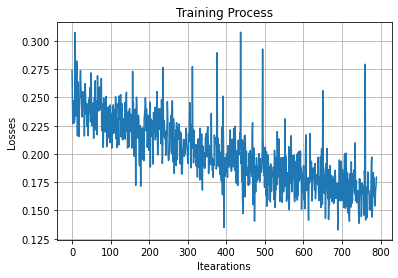

In [117]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(losses)

In [118]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.8652455449104309
0.7200747252056148


## Больше эпох

In [119]:
# symb_vocab_size, symb_embedding_dim, word_vocab_size, word_embedding_dim
model = WordSymbCNN(len(symbol2id), 8, len(word2id))
criterion = nn.BCELoss() # 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [120]:
set_random_seed(100)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = WordSymbTrain(model, train_iterator, val_iterator, optimizer, criterion, 15)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 11:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 15:   0%|          | 0/20000 [00:00<?, ?it/s]

In [121]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.5340316325426102
0.7491359390222637


## Улучшенная модель

In [209]:
class WordSymbCNN_upd(nn.Module):
  # накинем линейных слоев, изменим активацию на LeakyReLU и уберем пердобученные эмбеддинги
  # Добавим побольше параметров
    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # Word-level layers
        self.word_embedding = nn.Embedding(word_vocab_size, 300)
        self.word_hidden = nn.Linear(300, 100) 


        # Symbol-level layers
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=200, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=300, out_features=100)
        

        # Universal layers
        self.linear0 = nn.Linear(in_features=200, out_features=200)
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.7)
        self.relu = nn.LeakyReLU()   
        self.out = nn.Sigmoid()


    def forward(self, words_seq, symb_seq):
        #batch_size x seq_len
        embedded = self.symb_embedding(symb_seq)
        #batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1,2)
        #batch_size x embedding_dim x seq_len
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded))))
        #batch_size x filter_count2 x seq_len* 
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded))))
        #batch_size x filter_count3 x seq_len*

        pooling1 = feature_map_bigrams.max(2)[0] 
        # batch_size x filter_count2
        pooling2 = feature_map_trigrams.max(2)[0]
        # batch_size x filter_count3
        concat = torch.cat((pooling1, pooling2), 1)
        # batch_size x (filter_count2 + filter_count3)
        symb_vec = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq)   # переводим последовательность индексов в последовательность эмбеддингов
        mean_emb_words = torch.mean(embedded_words, dim=1) # считаем средний эмбеддинг предложения
        word_vec = self.dropout(self.word_hidden(mean_emb_words)) # пропускаем эмбеддинг через полносвязный слой 
        word_vec = self.dropout(self.relu(word_vec))

 
        concat = torch.cat((symb_vec, word_vec), 1)

        hidden = self.dropout(self.out(self.linear0(concat)))
        logits = self.out(self.linear(hidden))      
        return logits

In [210]:
# symb_vocab_size, symb_embedding_dim, word_vocab_size, word_embedding_dim
model = WordSymbCNN_upd(len(symbol2id), 10, len(word2id))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [211]:
set_random_seed(100)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = WordSymbTrain(model, train_iterator, val_iterator, optimizer, criterion, 15)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 11:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/80000 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 15:   0%|          | 0/20000 [00:00<?, ?it/s]

In [212]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.642875400185585
0.756948823950848


Модель чуток переобучилась но в принципе ок, качество улучшилось. Кажется, главное тут увеличение числа параметров как регуляризатор, чтобы их было не так легко выучить

In [213]:
preds = []
sentences = []
trues = []
for i, (word_seq, symb_seq, ys) in enumerate(val_iterator):   
    preds.extend(model(word_seq, symb_seq).cpu().detach().numpy().round())
    sentences.extend(word_seq)
val_sentences['pred'] = preds

In [217]:
# False positives
print('False positives', len(val_sentences[(val_sentences['pred'] == 1) & (val_sentences['tone'] == 0)]['text'].tolist()) / val_sentences.shape[0])
val_sentences[(val_sentences['pred'] == 1) & (val_sentences['tone'] == 0)]['text'].tolist()[:10]

False positives 0.15735


['@yakutenochka как же я тебя понимаю...(((',
 '@MrPushisty да не особо сложная, но она для os x, а зомби - наше все (((',
 '@Lightana_ не заметила, что тебя упомянула ((',
 '@potiekhina1923 @Potekhina1997 как горько видеть когда,браки рушаться(',
 'Всем нравятся мои перчатки, кроме меня :(',
 'RT @CIO_Optimal: @latnick65 Молодцы пенсионерки!!! Очень плохо, что мало таких...',
 '@LarryBestYou А когда это было?  Я не видела :(',
 '@luda_1D это можно просто писать?\nограничения есть?\nахах\nрасскажи, пожалуйста, а то я не знаю:(',
 'качество супер конечно :(\nтолько достал фотик и тут батарея разряжена ! http://t.co/tfNee94kkr',
 '@L_Agrippina зая, короче у меня мама дома :(\nдавай на недельке встретимся лучше??']

In [219]:
# False negatives
print('False negatives', len(val_sentences[(val_sentences['pred'] == 0) & (val_sentences['tone'] == 1)]['text'].tolist()) / val_sentences.shape[0])
val_sentences[(val_sentences['pred'] == 0) & (val_sentences['tone'] == 1)]['text'].tolist()[:10]

False negatives 0.10125


['2) Пунктуальность 4ever. Охрененно же, когда девушка опаздывает, а он угрюмо смотрит на её попытки перед ним извиниться.',
 '"Моются те,кому лень чесаться" А.Фоменко Выходит , я -ленивая)))))',
 'Я вот пальчик порезал нечаянно, сижу, кровь сосу :-)',
 '@maskuznetsova ааа! я чет сначала подумала что у Леши на три года) А Илари и Стива да, надо) А то мы не переживем)',
 'RT @AndreyShmidt98: Теперь блин жду не дождусь 21!)',
 'RT @cyluxiryfeku: у кого бы Nokia E90 потыркать? Охота попробовать, а на новую бабла жалко :)',
 'Дома так темно:)\nСтрашно мне одной летать в темноте ',
 'Встречал сегодня с утра гостей из Москвы, прокатил их как на катере по #Краснодар-у. )',
 'как попрет на умные мысли,высказывания ,фразы ,что аж блин не по себе становится :) http://t.co/sOUlNWedF2',
 'RT @sugekynoleva: Если у тебя проблема, попробуй ее решить. Не можешь ее решить, тогда не делай из этого проблемы) http://t.co/dBY468qGhO']

В отличие от модели на словах модель на символах примерно одинаково предсказывает фолс позитивы и фолс негативы. Видимо, из-за того что модель не только на словах, тут уже нет выделенных паттернов ошибок, как мы видели до этого. Что в принципе логично – чем сложнее модель, тем сложнее объяснить признаки

## Модель без предобработки текста

Давайте попробуем эту сетку на сырых данных

In [ ]:
vocab = Counter()
for line in tqdm(all_tweets_data.text):
    vocab.update(tt.tokenize(line))
    
word2id = {'PAD':0}

for word in vocab.keys():
    word2id[word] = len(word2id)

In [ ]:
char_vocab = Counter()
for line in tqdm(all_tweets_data.text):
    char_vocab.update(list(line))

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
symbol2id = {'PAD':0}

for symbol in char_vocab:
    symbol2id[symbol] = len(symbol2id)

In [ ]:
len(symbol2id)

366

In [ ]:
class RawWordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = tt.tokenize(self.dataset[index])
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch): #этот метод можно реализовывать и отдельно,
    # он понадобится для DataLoader во время итерации по батчам
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [ ]:
set_random_seed(100)
train_dataset = RawWordSymbDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [ ]:
set_random_seed(100)
val_dataset = RawWordSymbDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [ ]:
# symb_vocab_size, symb_embedding_dim, word_vocab_size, word_embedding_dim
model = WordSymbCNN(len(symbol2id), 8, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss() # 

# веса модели и значения лосса храним там же, где и все остальные тензоры
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [ ]:
set_random_seed(100)
losses, val_losses, val_losses_epoch, val_f1, val_f1_epoch = WordSymbTrain(model, train_iterator, val_iterator, optimizer, criterion, 10)

Training ... 


Epoch 1:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/20000 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/80000 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/20000 [00:00<?, ?it/s]

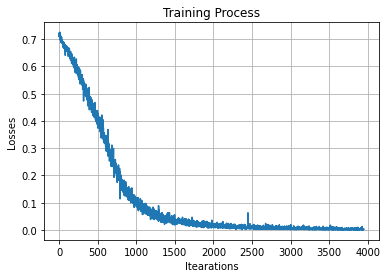

In [ ]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(train_losses)

In [ ]:
print(val_losses_epoch[-1])
print(val_f1_epoch[-1])

0.005089497752487659
0.9991282553881614


В общем, ясно, что тут в каждом тексте есть смайлики и модель просто выучивает соответствие :( - 0, :) - 1